In [1]:
import tensorflow 
import numpy as np
import pandas as pd
import pickle
import cv2
import keras
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, InputLayer, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.python.framework import ops
ops.get_default_graph()

Using TensorFlow backend.


In [2]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os
import shutil

#from skimage.io import imread
#from skimage.transform import resize
# Don't use skimage, it sucks (Can't read all iamges). Cv2 is better. 

In [3]:
from numpy import loadtxt
from tensorflow.keras.models import load_model

In [4]:
sess = tensorflow.compat.v1.Session(config=tensorflow.compat.v1.ConfigProto(log_device_placement=True))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

config = tensorflow.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tensorflow.compat.v1.Session(config=config) 
tensorflow.compat.v1.keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13629139598515922826
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9849081619739798770
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3264020480
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8966296752706065497
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5628677165803057986
physical_device_desc: "device: XLA_GPU 

In [5]:
EPOCHS = 100
INIT_LR = 1e-4
BS = 16
default_image_size = tuple((299, 299))
image_size = 0
directory_root = '../../../../Datasets/plant-seedlings-classification/train/' # Can be deleted
width=299
height=299
depth=3

In [6]:
iv3_model = load_model('InceptionV3_model1_12_categories_4750_plant_seedlings.h5')


In [69]:
image = cv2.imread('0bcf29af7.png')
image_resized = cv2.resize(image, default_image_size)/255.0

In [70]:
label_names = np.load('label_names.npy')
label_names = label_names.flatten()
label_names = np.ndarray.tolist(label_names)

In [71]:
#swapped = np.moveaxis(image_resized, 0, 2)  # shape (y_pixels, x_pixels, n_bands)
image_resized = np.expand_dims(image_resized, 0)

test_predictions = iv3_model.predict(image_resized)

In [72]:
predictions = np.argmax(test_predictions, axis=1)
label_names[int(predictions)]

'Cleavers'

In [65]:
# Visualizing heatmaps of class activation in an image
# Cross check one more time with the code from the book
# Revise and write in proper way

In [73]:
cleavers_output = iv3_model.output[:,np.argmax(test_predictions[0])]
last_conv_layer = iv3_model.get_layer('conv2d_93')
grads = K.gradients(cleavers_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([iv3_model.input],[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([image_resized])

for i in range(192):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)

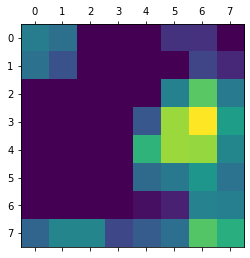

In [74]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.savefig('heat_map_cleavers.png', bbox_inches='tight')

In [75]:
img = cv2.imread('0bcf29af7.png')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('heat_map_superimposed_cleavers.png', superimposed_img)

True